In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data

ca_housing = pd.read_csv('housing.csv')
ca_housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [3]:
ca_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


As you can see the data seems clean and there is no null, except the total_bedrooms.

In [4]:
(ca_housing.isnull().sum()*100)/ca_housing.isnull().count()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

1% of the data is null so we can drop those.

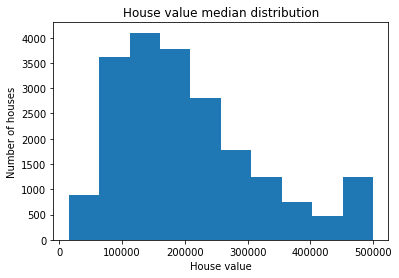

In [5]:
plt.hist(ca_housing['median_house_value'])
plt.title('House value median distribution')
plt.xlabel('House value')
plt.ylabel('Number of houses')
plt.show()

The house value distribution in not normal and highly skewed to right. Additionally, there is a jump at the end as well.
All the variables are numeric except the one of them, ocean_proximity.
Let's check the number of unique values of it and then transfer those values to numeric.

In [6]:
print('Unique calues of ocean proximty: {}'.format(ca_housing['ocean_proximity'].unique()))
print('Numer of unique value: {}'.format(ca_housing['ocean_proximity'].nunique()))

Unique calues of ocean proximty: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
Numer of unique value: 5


In [7]:
ca_housing = pd.concat([ca_housing,pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True)], axis=1)
dummy_columns = list(pd.get_dummies(ca_housing.ocean_proximity, prefix="ocean_proximity", drop_first=True).columns)
ca_housing = ca_housing.dropna()

In [8]:
X = ca_housing.drop(['median_house_value','ocean_proximity'], axis=1) 
Y = ca_housing['median_house_value']
ca_housing.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
longitude,1,-0.924616,-0.109357,0.0454802,0.069608,0.10027,0.0565128,-0.0155502,-0.0453982,-0.0553374,0.00950071,-0.474714,0.0461846
latitude,-0.924616,1,0.0118991,-0.0366668,-0.0669828,-0.108997,-0.0717742,-0.0796263,-0.144638,0.351084,-0.0166623,0.358785,-0.161342
housing_median_age,-0.109357,0.0118991,1,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.106432,-0.236968,0.0171053,0.256149,0.0207965
total_rooms,0.0454802,-0.0366668,-0.360628,1,0.93038,0.857281,0.918992,0.197882,0.133294,0.0264775,-0.00760262,-0.0236472,-0.00867431
total_bedrooms,0.069608,-0.0669828,-0.320451,0.93038,1,0.877747,0.979728,-0.00772285,0.0496862,-0.00646289,-0.00436147,-0.0198735,0.000679363
population,0.10027,-0.108997,-0.295787,0.857281,0.877747,1,0.907186,0.00508662,-0.0252997,-0.0196018,-0.0104505,-0.0614797,-0.0234983
households,0.0565128,-0.0717742,-0.302768,0.918992,0.979728,0.907186,1,0.0134339,0.0648935,-0.0382646,-0.00911926,-0.0112795,0.00210585
median_income,-0.0155502,-0.0796263,-0.118278,0.197882,-0.00772285,0.00508662,0.0134339,1,0.688355,-0.237536,-0.00928144,0.0566767,0.0273514
median_house_value,-0.0453982,-0.144638,0.106432,0.133294,0.0496862,-0.0252997,0.0648935,0.688355,1,-0.484787,0.0235251,0.160526,0.140378
ocean_proximity_INLAND,-0.0553374,0.351084,-0.236968,0.0264775,-0.00646289,-0.0196018,-0.0382646,-0.237536,-0.484787,1,-0.010681,-0.241356,-0.262289


1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

### Data Exploration

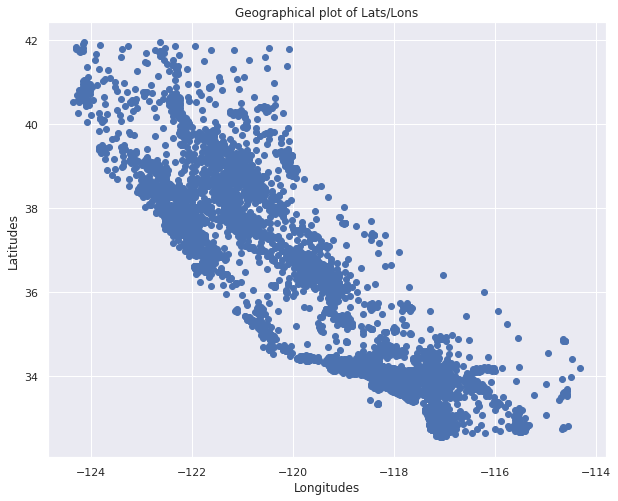

In [9]:
sns.set()
plt.figure(figsize=(10,8))#Figure size
plt.scatter('longitude','latitude',data=ca_housing)
plt.ylabel('Latitudes')
plt.xlabel('Longitudes')
plt.title('Geographical plot of Lats/Lons')
plt.show()

#### The plot looks like Calofornia.
But we don't have a informative look on the plot since we need to know the density for each point, let's do a simple modification.


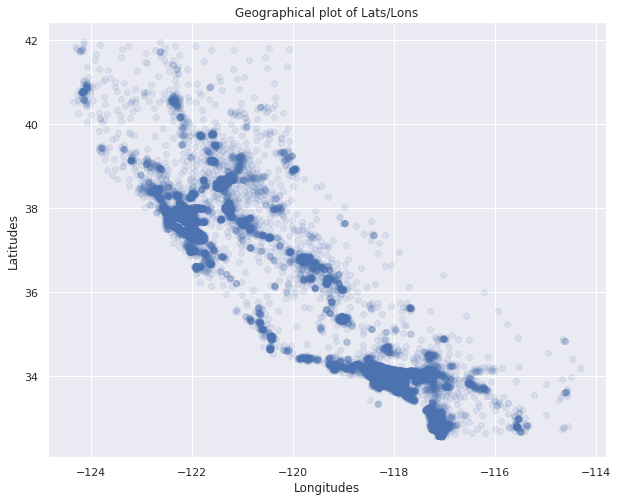

In [10]:
sns.set()
plt.figure(figsize=(10,8))#Figure size
plt.scatter('longitude','latitude',data=ca_housing,alpha=0.1)
plt.ylabel('Latitudes')
plt.xlabel('Longitudes')
plt.title('Geographical plot of Lats/Lons')
plt.show()

Now it's much better , and if we're familiar with Californias map we can see clearly that the high-density areas , namely the Bay Area and all around Los Angeles & San diego More generally our brains can spot patterns visually , but we always need to play around with the vizualisations to make the patterns stands out.

<Figure size 720x504 with 0 Axes>

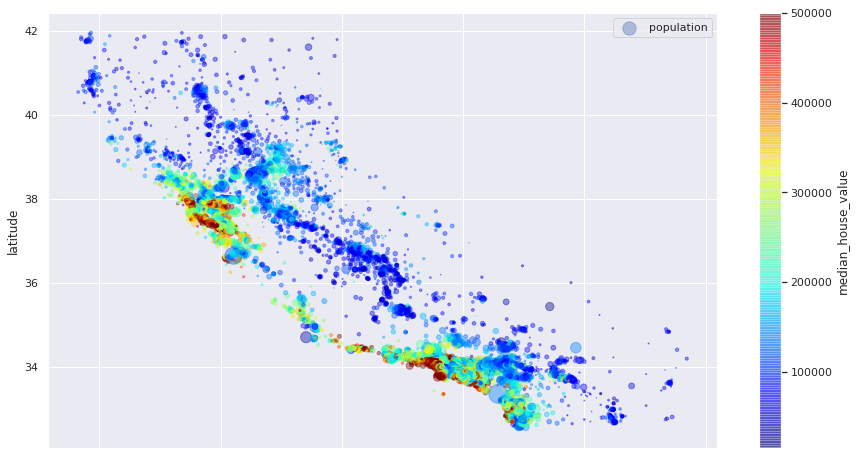

In [11]:
plt.figure(figsize=(10,7))
ca_housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=ca_housing["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()

Now we can say that the house price is a bit related to the location (e.g close to ocean) and to the density of the population.

In [12]:
corr_matrix=ca_housing.corr()
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.688355
ocean_proximity_NEAR BAY      0.160526
ocean_proximity_NEAR OCEAN    0.140378
total_rooms                   0.133294
housing_median_age            0.106432
households                    0.064894
total_bedrooms                0.049686
ocean_proximity_ISLAND        0.023525
population                   -0.025300
longitude                    -0.045398
latitude                     -0.144638
ocean_proximity_INLAND       -0.484787
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efce4bff7d0>,
      dtype=object)

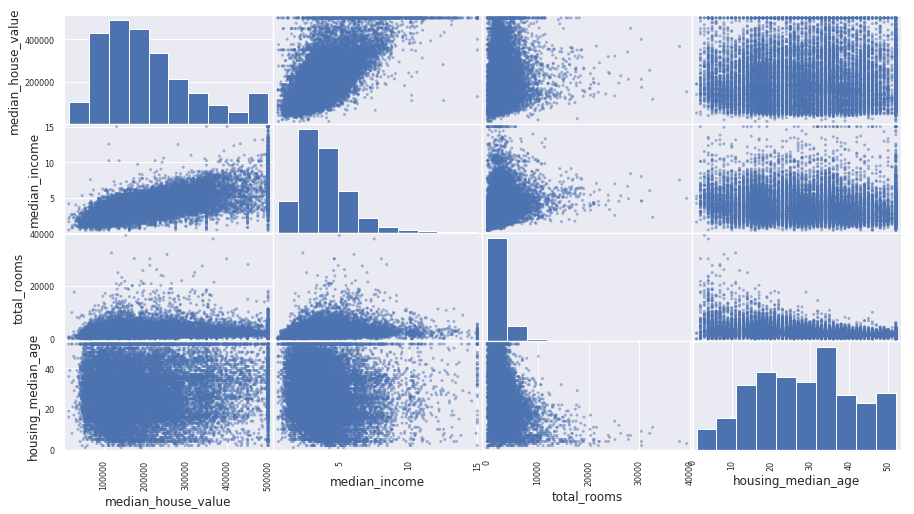

In [13]:

sns.set()
feat = ['median_house_value','median_income','total_rooms','housing_median_age']
pd.plotting.scatter_matrix(ca_housing[feat],figsize=(15,8))

In [14]:
ca_housing['rooms_per_household']= ca_housing['total_rooms'] / ca_housing.households

In [15]:
corr_matrix1=ca_housing.corr()
corr_matrix1.median_house_value.sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.688355
ocean_proximity_NEAR BAY      0.160526
rooms_per_household           0.151344
ocean_proximity_NEAR OCEAN    0.140378
total_rooms                   0.133294
housing_median_age            0.106432
households                    0.064894
total_bedrooms                0.049686
ocean_proximity_ISLAND        0.023525
population                   -0.025300
longitude                    -0.045398
latitude                     -0.144638
ocean_proximity_INLAND       -0.484787
Name: median_house_value, dtype: float64

The number of rooms per household is now more informative than the total number of rooms in a district

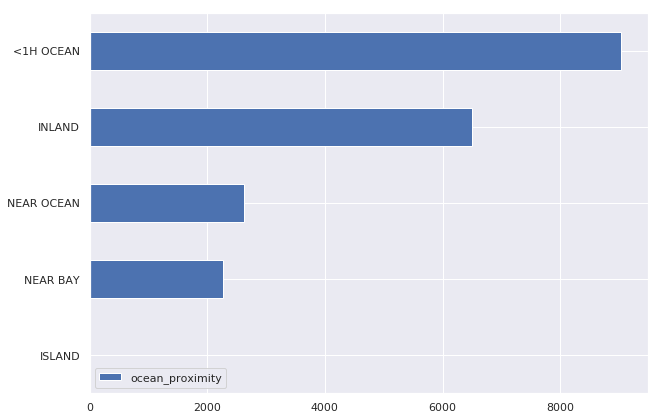

In [16]:
sns.set(palette='Set2')
ca_housing.ocean_proximity.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(10,7),color='b')
plt.legend()

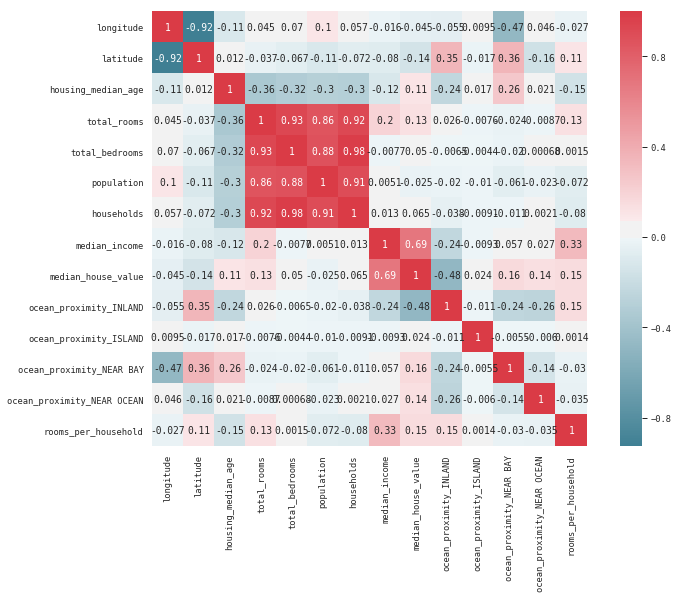

In [17]:
#heatmap using seaborn
#set the context for plotting 
sns.set(context="paper",font="monospace")
housing_corr_matrix = ca_housing.corr()
#set the matplotlib figure
fig, axe = plt.subplots(figsize=(12,8))
#Generate color palettes 
cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
#draw the heatmap
sns.heatmap(housing_corr_matrix,vmax=1,square =True, cmap=cmap,annot=True )

<Figure size 2160x3600 with 0 Axes>

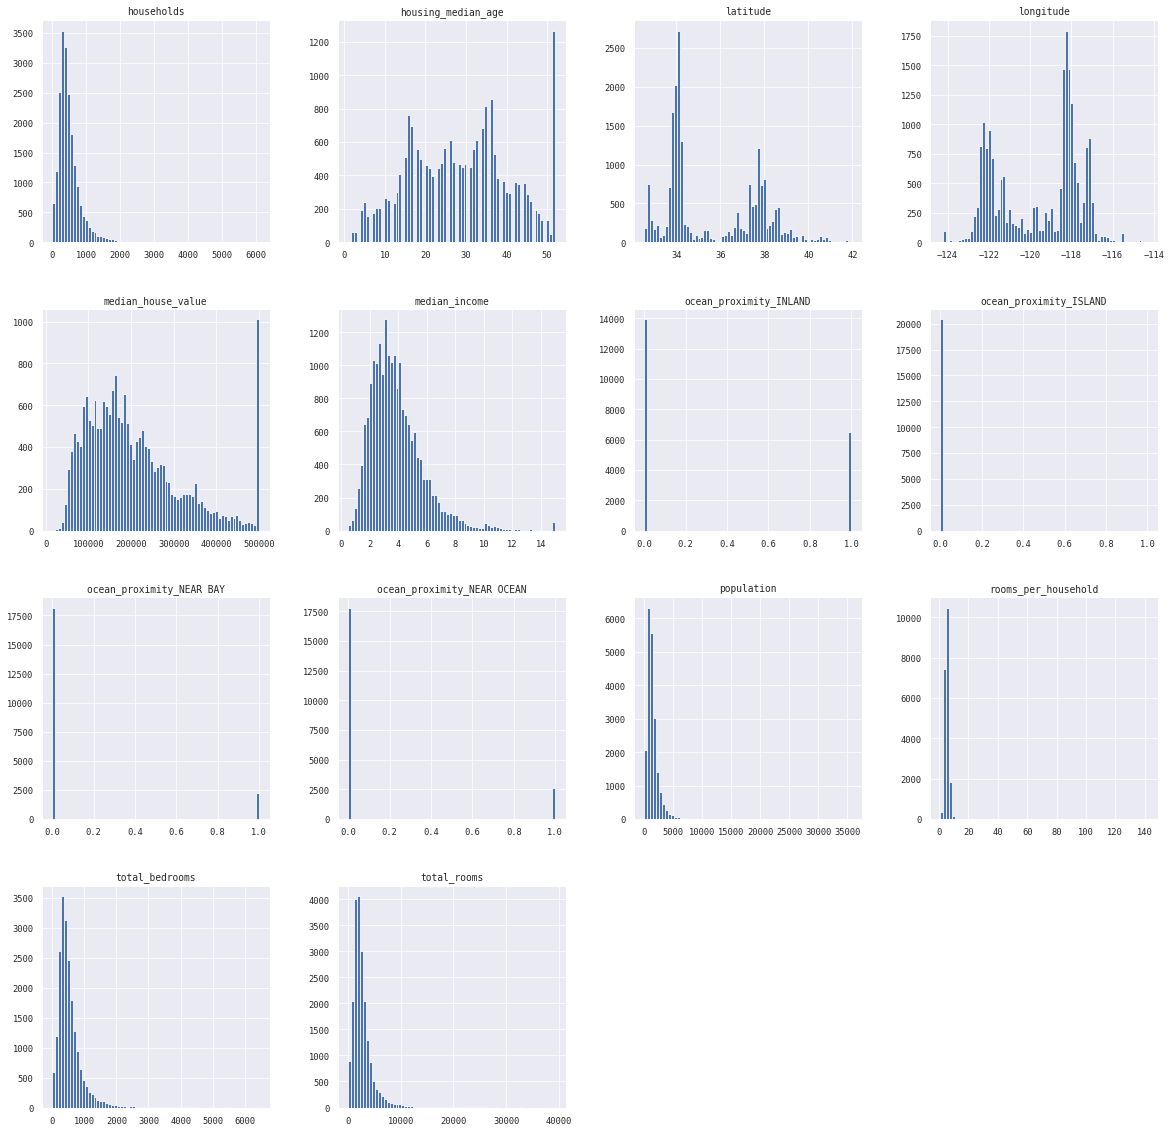

In [18]:
plt.figure(figsize=(30,50))

ca_housing.hist(bins=70, figsize=(20,20))

#    for index, column in enumerate(X.columns):
#        plt.subplot(3,4,index+1)
#        plt.bar(ca_housing.groupby(column)['median_house_value'].mean().index,
#              ca_housing.groupby(column)['median_house_value'].mean())
#        plt.title(column)
plt.show()

In [19]:
# creating linear regression model
lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

print('The linear model coefficients:', lrm.coef_)
print('The Linear model intercept:',lrm.intercept_)

The linear model coefficients: [-2.68129893e+04 -2.54821848e+04  1.07252004e+03 -6.19326372e+00
  1.00556290e+02 -3.79690829e+01  4.96173261e+01  3.92595729e+04
 -3.92843002e+04  1.52901941e+05 -3.95405162e+03  4.27813432e+03]
The Linear model intercept: -2269954.116133199


In [20]:

linear_pred = lrm.predict(X)
linear_errors = Y - linear_pred
print('The mean of linear regression errors is: {}'.format(np.mean(linear_errors)))

The mean of linear regression errors is: -3.4439746360272873e-10


In [21]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(linear_pred, linear_errors)
lev_stats = levene(linear_pred, linear_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 1832.97 and p value is 0
Levene test statistic value is 1791.38 and p value is 0


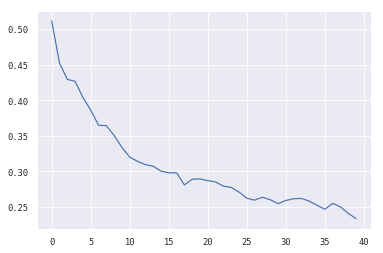

In [22]:
from statsmodels.tsa.stattools import acf

acf_data = acf(linear_errors)

plt.plot(acf_data[1:])
plt.show()

#### All the six requierments for the linear regression are meet.

In [23]:
# Now we will try creating linear regression model along with LASSO and Ridge

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 16346
The number of observations in test set is 4087
R-squared of the model in the training set is: 0.6458323519456107
-----Test set statistics-----
R-squared of the model in the test set is: 0.6481237469479318
Mean absolute error of the prediction is: 49764.03119872527
Mean squared error of the prediction is: 4813702014.621097
Root mean squared error of the prediction is: 69380.84760667814
Mean absolute percentage error of the prediction is: 28.721199154751915


In [24]:
print('The linear model coefficients:', lrm.coef_)
print('The Linear model intercept:',lrm.intercept_)

The linear model coefficients: [-2.66276346e+04 -2.51226176e+04  1.10033626e+03 -6.27434261e+00
  9.34170725e+01 -3.62226764e+01  5.35253622e+01  3.93553595e+04
 -3.89608194e+04  1.54692970e+05 -5.36562974e+03  3.51994164e+03]
The Linear model intercept: -2262362.9815725707


The coefficients tells that the following four factor has positive effect on house prices:
1. Housing median Age
2. Houshoulds Income
3. Near Island
4. Near Ocean

In [25]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=10**2) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.6453030667736448
-----Test set statistics-----
R-squared of the model on the test set is: 0.6480711519369318
Mean absolute error of the prediction is: 49781.19005027163
Mean squared error of the prediction is: 4814421519.584032
Root mean squared error of the prediction is: 69386.03259723121
Mean absolute percentage error of the prediction is: 28.76558749781323


In [26]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**2) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.6452570358555139
-----Test set statistics-----
R-squared of the model on the test set is: 0.6481542209844007
Mean absolute error of the prediction is: 49777.967117915534
Mean squared error of the prediction is: 4813285126.782059
Root mean squared error of the prediction is: 69377.84319782548
Mean absolute percentage error of the prediction is: 28.73640987501499


In [27]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**2, l1_ratio=5e-20) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))



R-squared of the model on the training set is: 0.1746666574619865
-----Test set statistics-----
R-squared of the model on the test set is: 0.18248038443701553
Mean absolute error of the prediction is: 82751.40603227615
Mean squared error of the prediction is: 11183749361.58447
Root mean squared error of the prediction is: 105753.24752263862
Mean absolute percentage error of the prediction is: 55.667225252146125


In [28]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

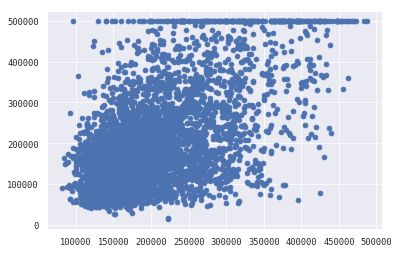

In [29]:
knn_pred = knn.predict(X_test)
knn_errors = y_test - knn_pred
plt.scatter(knn_pred,y_test)

In [30]:
X = ca_housing.drop(['median_house_value','ocean_proximity'], axis=1) 
Y = ca_housing['median_house_value']

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(X_train)



In [31]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')

knn_w.fit(X, Y)



Y_ = knn_w.predict(X)



In [32]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.19 (+/- 0.19)
Weighted Accuracy: 0.20 (+/- 0.19)


In [33]:
from sklearn.ensemble import RandomForestRegressor


random_forest = RandomForestRegressor()
random_forest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:

random_forest.score(X_train,y_train)

0.9653574070826452

And that's 96% accuracy of the model's values with the actual values. This means that the model passes through 96% of the actual data points!

In [35]:
pred_random_forest_test = random_forest.predict(X_test)
random_forest.score(X_test,y_test)

0.8071626111768055

As we can see our Random Forest model overfittiong, so I will reduce the numbers of estimators and increase the maximum depth to regularize.

In [36]:
params = {'n_estimators': 8,
         'max_depth': 8}

random_forest1 = RandomForestRegressor(**params)
random_forest1.fit(X_train,y_train)
random_forest1.score(X_train,y_train)

0.7846304689957445

In [37]:
pred_random_forest_test = random_forest1.predict(X_test)
random_forest1.score(X_test,y_test)

0.7413979023743383

Now the difference between the training data and test data is close.

In [38]:
from sklearn.svm import SVR
svr = SVR()

svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
svr.score(X_train,y_train)

-0.05580398384338925

In [40]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([-0.03194331, -0.15747785, -0.28730473, -0.00147687, -0.1853984 ])

In [41]:
cross_val_score(svr, X_test, y_test, cv=5)

array([-0.050807  , -0.07259526, -0.04565146, -0.0551111 , -0.04098496])

In [42]:
#Gradient descent boosting

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

params = {'n_estimators': 100,
         'max_depth': 3,
         'loss': 'lad'}

#instantiate and fit
gbr = ensemble.GradientBoostingRegressor(**params)
cross_val_score(gbr, X_train, y_train, cv=5)

array([0.72226334, 0.70647664, 0.73987547, 0.69829183, 0.72751519])

In [43]:
print('mean = {:.3}'.format(cross_val_score(gbr, X_train, y_train, cv=5).mean()))

mean = 0.717


In [44]:
gbr.fit(X_train, y_train)
gbr.score(X_train, y_train)

0.7137181625707436

In [45]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=5)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [46]:
decision_tree.score(X_train, y_train)

0.646338786138026

In [47]:
pred_tree = decision_tree.predict(X_test)

from sklearn.metrics import explained_variance_score

explained_variance_score(y_test,pred_tree,multioutput='uniform_average')


0.617142154240162

Comparing different models shows that "Forest Ensemble" have the most accurate percision among other regression models.